# LA Crime Prediction (2020–Present) — Calibrated Perceptron

**Goal:** Predict whether an incident is **Part 1 (serious)** or **Part 2 (non-serious)** using Los Angeles open crime data, with a **calibrated Perceptron** and a reproducible scikit-learn pipeline.

**TL;DR (Results)**  
- Model: `Perceptron + OneHot(min_frequency=50) + StandardScaler`, probabilities via sigmoid calibration  
- Metrics (example): `Accuracy ≈ ...`, `F1-macro ≈ ...`, `ROC-AUC ≈ ...`  
- Key signals: time-of-day, weapon type, premises, area  
- Baselines: beats both “Most Frequent” and “Stratified Random” by a large margin

> This notebook is structured like a professional DS workflow: data loading → cleaning → features → CV & calibration → evaluation → explainability → artifacts.


## Table of Contents
1. [Reproducibility & Setup](#repro)
2. [Data Loading](#data)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Cleaning & Feature Engineering](#fe)
5. [Model Training & Calibration](#model)
6. [Train / Validation Strategy](#train)
7. [Evaluation & Baselines](#eval)
8. [Permutation Importance (Explainability)](#perm)
9. [Artifacts & Persistence](#artifacts)
10. [Visual Highlights](#viz)
11. [Ethics, Bias & Limitations](#ethics)
12. [How to Reproduce](#repro_steps)
13. [Appendix: Environment & Versions](#appendix)


<a id="repro"></a>

## 1) Reproducibility & Setup

- Random seed fixed (`SEED=42`)
- Environment captured (Python & library versions)
- Data file hash saved when loading from local/Drive
- Pipeline components are version-agnostic (ColumnTransformer + Pipelines)

> If you are running this in Colab, ensure you install requirements in a separate code cell:
>
> `!pip install pandas numpy matplotlib seaborn scikit-learn scipy joblib contextily geopandas eli5`


In [2]:
# ML Project 1: LAPD Crime Prediction with Perceptron #
!pip install contextily

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import sys, platform, json, hashlib, warnings
warnings.filterwarnings("ignore")
import joblib
import json
import hashlib

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_auc_score)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance

SEED = 42
np.random.seed(SEED)

PROJ_DIR      = Path.cwd()
DATA_DIR      = PROJ_DIR / "data"
ARTIFACTS_DIR = PROJ_DIR / "artifacts"
DATA_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Set your file path if not already loaded elsewhere:
LOCAL_CSV = DATA_DIR / "Crime_Data_from_2020_to_Present.csv"

def file_sha256(p: Path, block_size=1<<20) -> str:
    h = hashlib.sha256()
    with open(p, "rb") as f:
        while (b := f.read(block_size)):
            h.update(b)
    return h.hexdigest()

ENV = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "pandas": pd.__version__,
}

<a id="data"></a>

## 2) Data Loading

**Primary** (shareable): Public Github file link

**Notes**
- This dataset typically has **1.5M+ rows** spanning 2020–present.
- We load only the columns we need for modeling and plots.


In [3]:
github_raw_url = 'https://media.githubusercontent.com/media/syed-arib-hasan/ps/refs/heads/main/Crime_Data_from_2020_to_Present.csv'

try:
    df = pd.read_csv(github_raw_url)
    print("Dataset loaded successfully from GitHub.")
    display(df.head())
except Exception as e:
    print(f"Error loading data from GitHub: {e}")
    print("Please ensure you have the correct raw URL.")

Dataset loaded successfully from GitHub.


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


<a id="eda"></a>

## 3) Exploratory Data Analysis (EDA)

**We explore**:
- Temporal: year, month, weekday, hour
- Spatial: area names, coordinate scatter (optional map background)
- Context: premises, weapons
- Demographics: victim age/sex (used carefully)

**Why it matters**: EDA guides feature selection, reveals data quality issues (missingness, outliers), and suggests useful transformations (e.g., hour-of-day from TIME OCC).


In [4]:
# A look into the Dataset
print("Rows, Cols:", df.shape)
df.head()

Rows, Cols: (990293, 28)


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


In [5]:
#Basic information
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990293 entries, 0 to 990292
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           990293 non-null  int64  
 1   Date Rptd       990293 non-null  object 
 2   DATE OCC        990293 non-null  object 
 3   TIME OCC        990293 non-null  int64  
 4   AREA            990293 non-null  int64  
 5   AREA NAME       990293 non-null  object 
 6   Rpt Dist No     990293 non-null  int64  
 7   Part 1-2        990293 non-null  int64  
 8   Crm Cd          990293 non-null  int64  
 9   Crm Cd Desc     990293 non-null  object 
 10  Mocodes         842641 non-null  object 
 11  Vict Age        990293 non-null  int64  
 12  Vict Sex        849515 non-null  object 
 13  Vict Descent    849504 non-null  object 
 14  Premis Cd       989970 non-null  float64
 15  Premis Desc     989399 non-null  object 
 16  Weapon Used Cd  326547 non-null  float64
 17  Weapon Des

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
count,9.902930e+05,990293.000000,990293.000000,990293.000000,990293.000000,990293.000000,990293.000000,989970.000000,326547.000000,990282.000000,68957.000000,2311.000000,64.00000,990293.000000,990293.000000
mean,2.199083e+08,1339.256672,10.697314,1116.172073,1.402950,500.675146,29.011584,305.964166,363.873623,500.431720,958.159752,984.204673,991.21875,33.986463,-118.050015
std,1.303375e+07,651.351436,6.108960,611.015402,0.490491,205.914118,21.982132,219.200779,123.703129,205.713105,110.251655,51.485644,27.06985,1.730076,5.997837
min,8.170000e+02,1.000000,1.000000,101.000000,1.000000,110.000000,-4.000000,101.000000,101.000000,110.000000,210.000000,310.000000,821.00000,0.000000,-118.667600
25%,2.106116e+08,900.000000,5.000000,587.000000,1.000000,331.000000,0.000000,101.000000,311.000000,331.000000,998.000000,998.000000,998.00000,34.014600,-118.430400
50%,2.209048e+08,1420.000000,11.000000,1141.000000,1.000000,442.000000,30.000000,203.000000,400.000000,442.000000,998.000000,998.000000,998.00000,34.058900,-118.322500
75%,2.310090e+08,1900.000000,16.000000,1617.000000,2.000000,626.000000,44.000000,501.000000,400.000000,626.000000,998.000000,998.000000,998.00000,34.164900,-118.273900
max,2.499289e+08,2359.000000,21.000000,2199.000000,2.000000,956.000000,120.000000,976.000000,516.000000,956.000000,999.000000,999.000000,999.00000,34.334300,0.000000


In [6]:
# Missing values per column
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))


Missing values per column:
Crm Cd 4          990229
Crm Cd 3          987982
Crm Cd 2          921336
Cross Street      837652
Weapon Used Cd    663746
Weapon Desc       663746
Mocodes           147652
Vict Descent      140789
Vict Sex          140778
Premis Desc          894
Premis Cd            323
Crm Cd 1              11
Status                 1
Vict Age               0
Crm Cd                 0
Crm Cd Desc            0
AREA NAME              0
Rpt Dist No            0
AREA                   0
TIME OCC               0
Date Rptd              0
DATE OCC               0
DR_NO                  0
Part 1-2               0
Status Desc            0
LOCATION               0
LAT                    0
LON                    0
dtype: int64


In [7]:
# For numeric columns
print("\nNumeric summary:")
print(df.describe(include=[np.number]).T)

# For categorical columns
print("\nCategorical summary:")
print(df.describe(include=['object']).T)


Numeric summary:
                   count          mean           std       min           25%  \
DR_NO           990293.0  2.199083e+08  1.303375e+07  817.0000  2.106116e+08   
TIME OCC        990293.0  1.339257e+03  6.513514e+02    1.0000  9.000000e+02   
AREA            990293.0  1.069731e+01  6.108960e+00    1.0000  5.000000e+00   
Rpt Dist No     990293.0  1.116172e+03  6.110154e+02  101.0000  5.870000e+02   
Part 1-2        990293.0  1.402950e+00  4.904912e-01    1.0000  1.000000e+00   
Crm Cd          990293.0  5.006751e+02  2.059141e+02  110.0000  3.310000e+02   
Vict Age        990293.0  2.901158e+01  2.198213e+01   -4.0000  0.000000e+00   
Premis Cd       989970.0  3.059642e+02  2.192008e+02  101.0000  1.010000e+02   
Weapon Used Cd  326547.0  3.638736e+02  1.237031e+02  101.0000  3.110000e+02   
Crm Cd 1        990282.0  5.004317e+02  2.057131e+02  110.0000  3.310000e+02   
Crm Cd 2         68957.0  9.581598e+02  1.102517e+02  210.0000  9.980000e+02   
Crm Cd 3          2311

In [8]:
#Unique Values per column
unique_counts = df.nunique().sort_values(ascending=False)
print("Unique value counts per column:\n", unique_counts)


Unique value counts per column:
 DR_NO             990293
Mocodes           309791
LOCATION           66366
Cross Street       10353
LAT                 5424
LON                 4981
DATE OCC            1763
Date Rptd           1763
TIME OCC            1439
Rpt Dist No         1210
Premis Cd            314
Premis Desc          306
Crm Cd 1             142
Crm Cd               140
Crm Cd Desc          140
Crm Cd 2             126
Vict Age             104
Weapon Used Cd        79
Weapon Desc           79
Crm Cd 3              37
AREA                  21
AREA NAME             21
Vict Descent          20
Status                 6
Crm Cd 4               6
Status Desc            6
Vict Sex               5
Part 1-2               2
dtype: int64


In [9]:
# Top crime types
print("\nTop 10 Crime Types:")
print(df['Crm Cd Desc'].value_counts().head(10))

# Top Areas
print("\nTop 10 Areas:")
print(df['AREA NAME'].value_counts().head(10))

# Premises
print("\nTop 10 Premises:")
print(df['Premis Desc'].value_counts().head(10))

# Weapons
print("\nTop 10 Weapons:")
print(df['Weapon Desc'].value_counts().head(10))

# Part 1 vs Part 2
print("\nCrime Severity (Part 1-2):")
print(df['Part 1-2'].value_counts())


Top 10 Crime Types:
Crm Cd Desc
VEHICLE - STOLEN                                           112502
BATTERY - SIMPLE ASSAULT                                    74747
BURGLARY FROM VEHICLE                                       61944
THEFT OF IDENTITY                                           61413
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     60082
BURGLARY                                                    57794
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              53441
THEFT PLAIN - PETTY ($950 & UNDER)                          52112
INTIMATE PARTNER - SIMPLE ASSAULT                           46705
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             40188
Name: count, dtype: int64

Top 10 Areas:
AREA NAME
Central        68421
77th Street    61153
Pacific        58378
Southwest      56491
Hollywood      51726
N Hollywood    50370
Olympic        49416
Southeast      49414
Newton         48558
Wilshire       47472
Name: count, dtype: int64

Top 10 Premises:
Pr

In [10]:
# Victim age distribution
print(df['Vict Age'].describe())

# Check weird ages
print("Number of victims with age > 120:", (df['Vict Age'] > 120).sum())
print("Number of victims with age <= 0:", (df['Vict Age'] <= 0).sum())

count    990293.000000
mean         29.011584
std          21.982132
min          -4.000000
25%           0.000000
50%          30.000000
75%          44.000000
max         120.000000
Name: Vict Age, dtype: float64
Number of victims with age > 120: 0
Number of victims with age <= 0: 263325


In [11]:
#Understanding Time Features
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])

print("Crimes per year:")
print(df['DATE OCC'].dt.year.value_counts().sort_index())

print("\nCrimes per month:")
print(df['DATE OCC'].dt.month.value_counts().sort_index())

# Extract hour if not done yet
df['Hour'] = (df['TIME OCC'] // 100).astype(int)
print("\nCrimes by hour of day:")
print(df['Hour'].value_counts().sort_index())

Crimes per year:
DATE OCC
2020    199806
2021    209831
2022    235189
2023    232216
2024    113251
Name: count, dtype: int64

Crimes per month:
DATE OCC
1     92606
2     86325
3     87734
4     83467
5     82963
6     81318
7     83861
8     83706
9     80758
10    82285
11    71773
12    73497
Name: count, dtype: int64

Crimes by hour of day:
Hour
0     40006
1     29360
2     24904
3     21904
4     18526
5     17073
6     22846
7     25896
8     36763
9     36022
10    42393
11    43041
12    66785
13    44930
14    48575
15    52024
16    52153
17    57831
18    59004
19    54727
20    55442
21    50055
22    48370
23    41663
Name: count, dtype: int64


In [12]:
#Missing Value Percentage
missing = (df.isnull().sum() / len(df)) * 100
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing Value Percentage:\n", missing)

Missing Value Percentage:
 Crm Cd 4          99.993537
Crm Cd 3          99.766635
Crm Cd 2          93.036707
Cross Street      84.586279
Weapon Desc       67.025214
Weapon Used Cd    67.025214
Mocodes           14.909931
Vict Descent      14.216903
Vict Sex          14.215793
Premis Desc        0.090276
Premis Cd          0.032617
Crm Cd 1           0.001111
Status             0.000101
dtype: float64


In [13]:
#Understanding Spatial Information
print("Latitude range:", df['LAT'].min(), "to", df['LAT'].max())
print("Longitude range:", df['LON'].min(), "to", df['LON'].max())

# Missing coordinates?
print("Missing LAT/LON:", df['LAT'].isna().sum(), df['LON'].isna().sum())

Latitude range: 0.0 to 34.3343
Longitude range: -118.6676 to 0.0
Missing LAT/LON: 0 0


In [14]:
#Descriptive Statistics Summary
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'n_unique': df.nunique(),
    'n_missing': df.isna().sum(),
    'missing_%': (df.isna().sum()/len(df))*100,
    'sample_values': [df[col].dropna().unique()[:5] for col in df.columns]
})

pd.set_option('display.max_colwidth', None)
summary


,dtype,n_unique,n_missing,missing_%,sample_values
DR_NO,int64,990293,0,0.000000,"[190326475, 200106753, 200320258, 200907217, 220614831]"
Date Rptd,datetime64[ns],1763,0,0.000000,"[2020-03-01 00:00:00, 2020-02-09 00:00:00, 2020-11-11 00:00:00, 2023-05-10 00:00:00, 2022-08-18 00:00:00]"
DATE OCC,datetime64[ns],1763,0,0.000000,"[2020-03-01 00:00:00, 2020-02-08 00:00:00, 2020-11-04 00:00:00, 2020-03-10 00:00:00, 2020-08-17 00:00:00]"
TIME OCC,int64,1439,0,0.000000,"[2130, 1800, 1700, 2037, 1200]"
AREA,int64,21,0,0.000000,"[7, 1, 3, 9, 6]"
AREA NAME,object,21,0,0.000000,"[Wilshire, Central, Southwest, Van Nuys, Hollywood]"
Rpt Dist No,int64,1210,0,0.000000,"[784, 182, 356, 964, 666]"
Part 1-2,int64,2,0,0.000000,"[1, 2]"
Crm Cd,int64,140,0,0.000000,"[510, 330, 480, 343, 354]"
Crm Cd Desc,object,140,0,0.000000,"[VEHICLE - STOLEN, BURGLARY FROM VEHICLE, BIKE - STOLEN, SHOPLIFTING-GRAND THEFT ($950.01 & OVER), THEFT OF IDENTITY]"


**Visualizations**

In [15]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

df_sample = df.sample(50000, random_state=42) if len(df) > 100000 else df.copy()
print("Using sample of", len(df_sample), "rows.")

Using sample of 50000 rows.


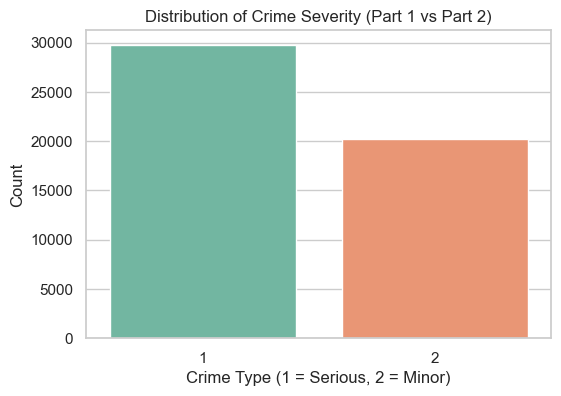

In [16]:
# Distribution of Crime Severity
plt.figure(figsize=(6,4))
sns.countplot(x='Part 1-2', data=df_sample, palette='Set2', hue='Part 1-2', legend=False)
plt.title("Distribution of Crime Severity (Part 1 vs Part 2)")
plt.xlabel("Crime Type (1 = Serious, 2 = Minor)")
plt.ylabel("Count")
plt.show()

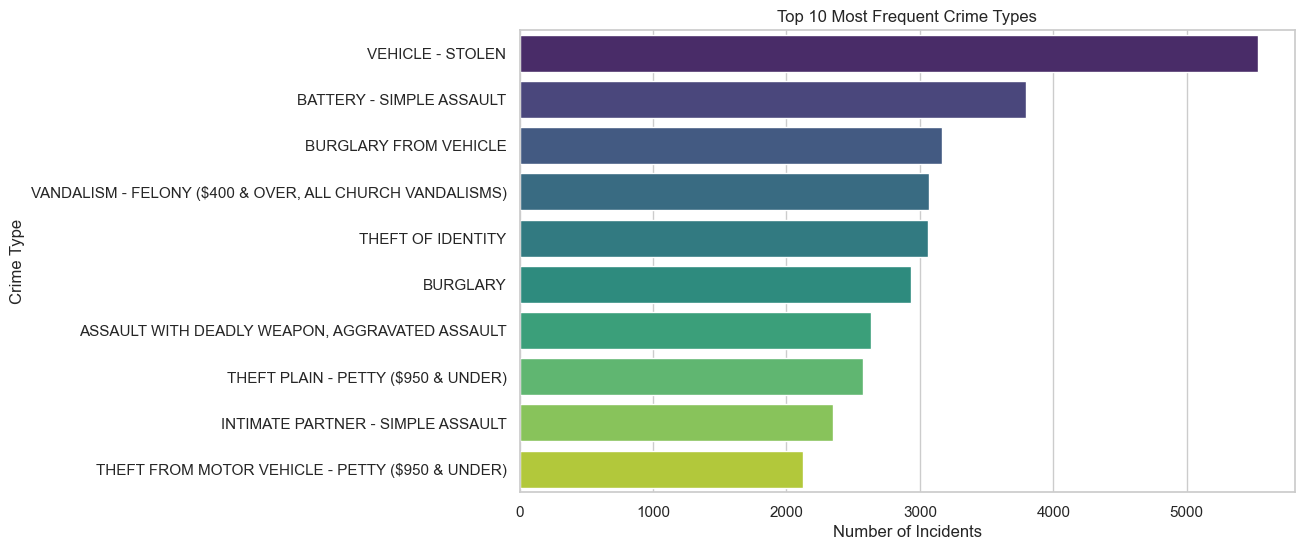

In [17]:
# Top Crime Categories
top_crimes = df_sample['Crm Cd Desc'].value_counts().head(10)
sns.barplot(y=top_crimes.index, x=top_crimes.values, palette='viridis', hue=top_crimes.index, legend=False)
plt.title("Top 10 Most Frequent Crime Types")
plt.xlabel("Number of Incidents")
plt.ylabel("Crime Type")
plt.show()

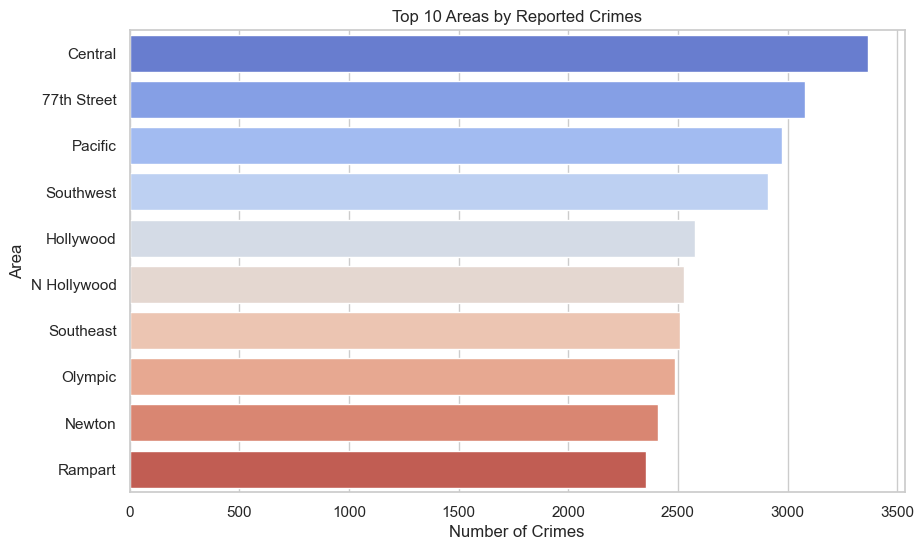

In [18]:
#Crime by Area
top_areas = df_sample['AREA NAME'].value_counts().head(10)
sns.barplot(y=top_areas.index, x=top_areas.values, palette='coolwarm', hue=top_areas.index, legend=False)
plt.title("Top 10 Areas by Reported Crimes")
plt.xlabel("Number of Crimes")
plt.ylabel("Area")
plt.show()

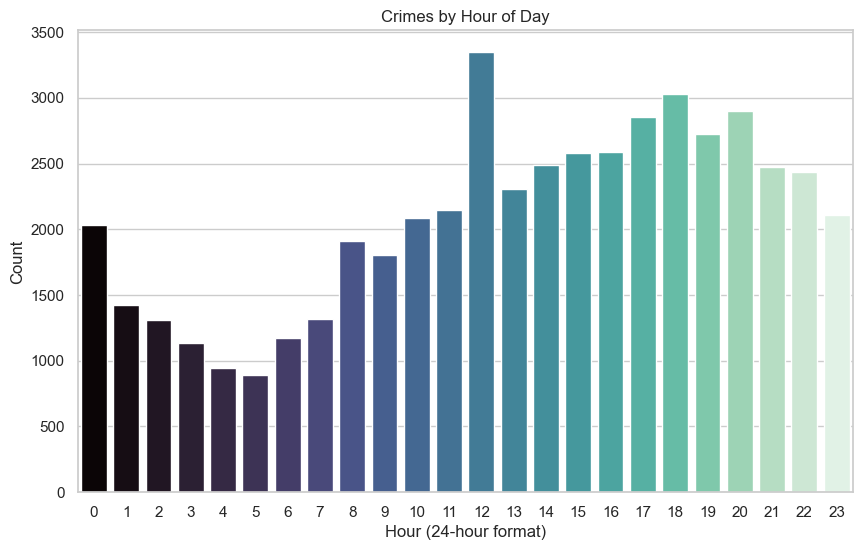

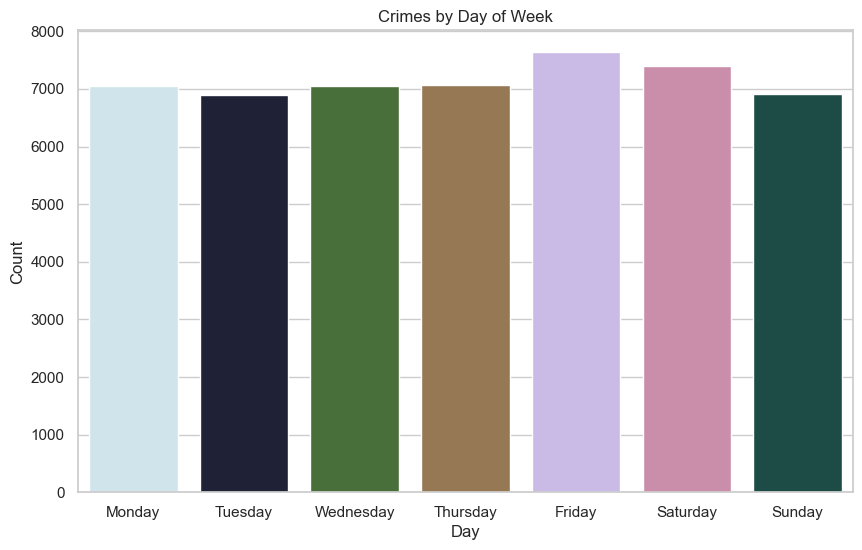

In [19]:
#Crime by Time of Day
df_sample['Hour'] = (df_sample['TIME OCC'] // 100).astype(int)
sns.countplot(x='Hour', data=df_sample, palette='mako', hue='Hour', legend=False)
plt.title("Crimes by Hour of Day")
plt.xlabel("Hour (24-hour format)")
plt.ylabel("Count")
plt.show()

#Crime by Day of Week
df_sample['DATE OCC'] = pd.to_datetime(df_sample['DATE OCC'])
df_sample['DayOfWeek'] = df_sample['DATE OCC'].dt.day_name()

order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(x='DayOfWeek', data=df_sample, order=order, palette='cubehelix', hue='DayOfWeek', legend=False)
plt.title("Crimes by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()

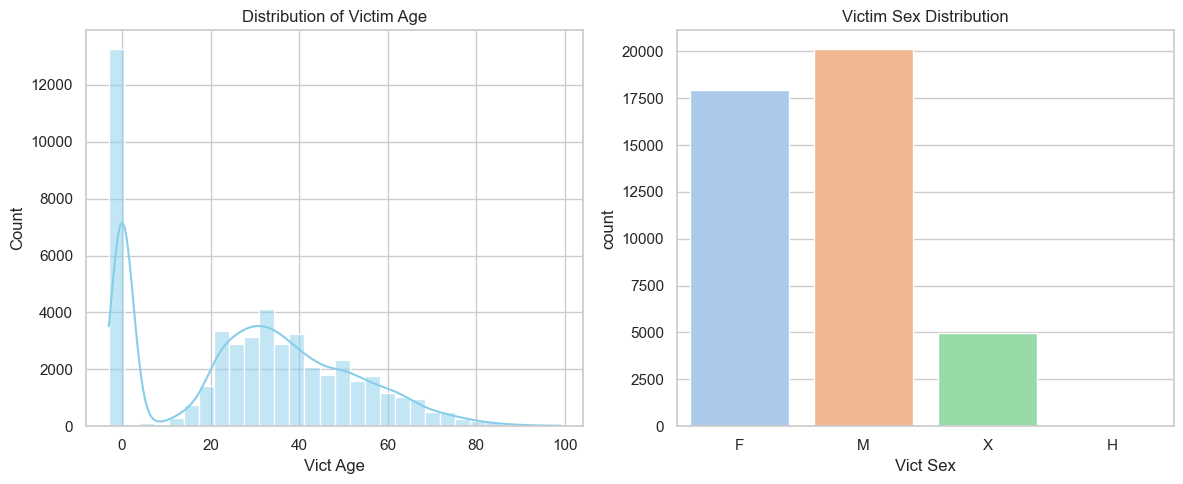

In [20]:
#Victim Demographics
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df_sample['Vict Age'], bins=30, ax=ax[0], color='skyblue', kde=True)
ax[0].set_title("Distribution of Victim Age")

sns.countplot(x='Vict Sex', data=df_sample, ax=ax[1], palette='pastel', hue='Vict Sex', legend=False)
ax[1].set_title("Victim Sex Distribution")

plt.tight_layout()
plt.show()

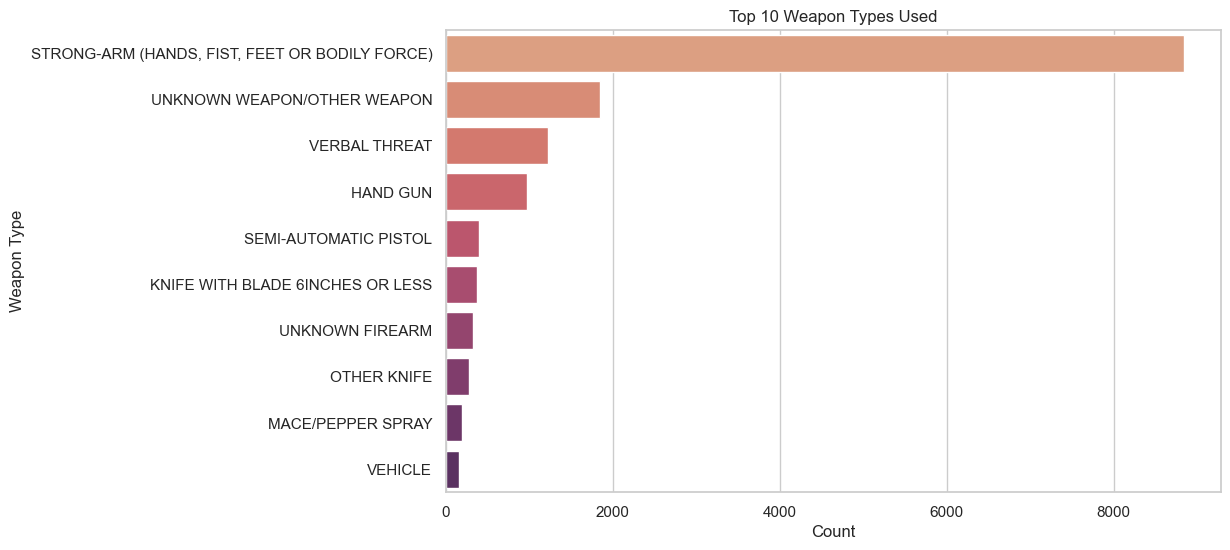

In [21]:
#Weapon Usage
top_weapons = df_sample['Weapon Desc'].value_counts().head(10)
sns.barplot(y=top_weapons.index, x=top_weapons.values, palette='flare', hue=top_weapons.index, legend=False)
plt.title("Top 10 Weapon Types Used")
plt.xlabel("Count")
plt.ylabel("Weapon Type")
plt.show()

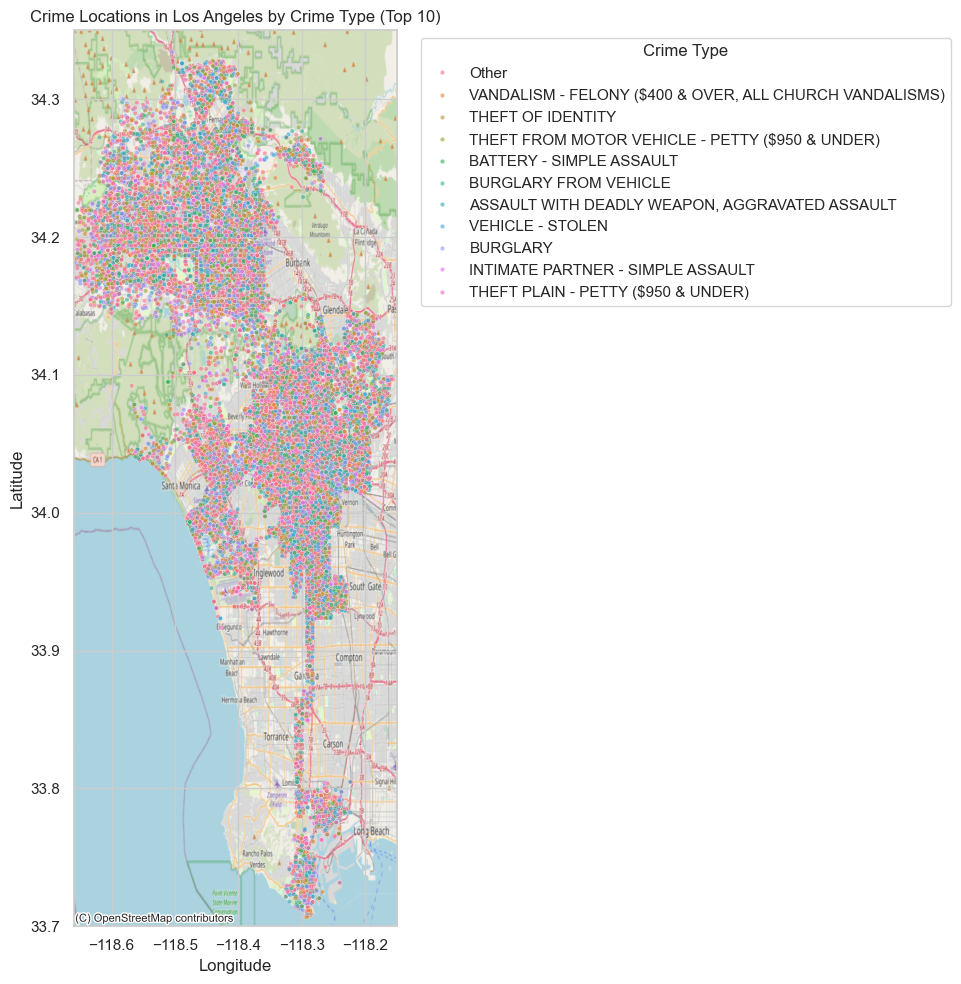

In [22]:
# Filter out outlier coordinates (0.0 for lat or lon)
df_filtered = df_sample[(df_sample['LAT'] != 0.0) & (df_sample['LON'] != 0.0)].copy()

# Get top 10 crime types
top_10_crimes = df_filtered['Crm Cd Desc'].value_counts().nlargest(10).index.tolist()

# Create a new column for coloring: top 10 crime types or 'Other'
df_filtered['crime_color'] = df_filtered['Crm Cd Desc'].apply(lambda x: x if x in top_10_crimes else 'Other')

# Plot crime locations colored by crime type
plt.figure(figsize=(10, 10))

sns.scatterplot(data=df_filtered, x='LON', y='LAT', hue='crime_color', s=10, alpha=0.6)

plt.title("Crime Locations in Los Angeles by Crime Type (Top 10)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot limits to focus on Los Angeles (approximate bounding box)
plt.xlim([-118.66, -118.15])
plt.ylim([33.70, 34.35])

# Add basemap
ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()

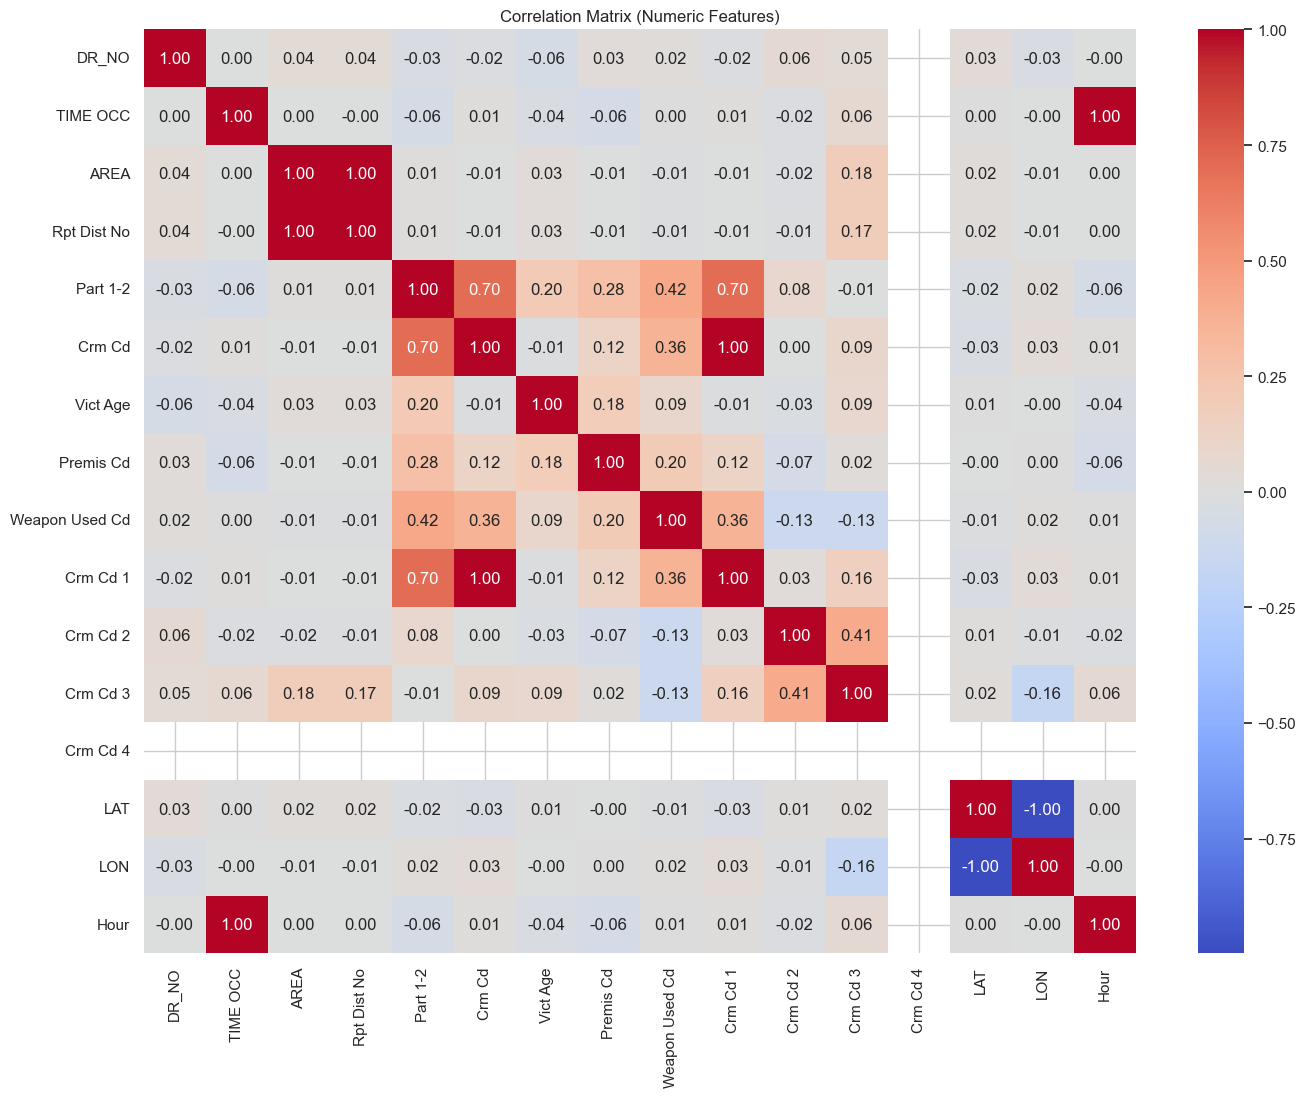

In [23]:
#Correlation Heatmap
numeric_cols = df_sample.select_dtypes(include=[np.number])
corr = numeric_cols.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

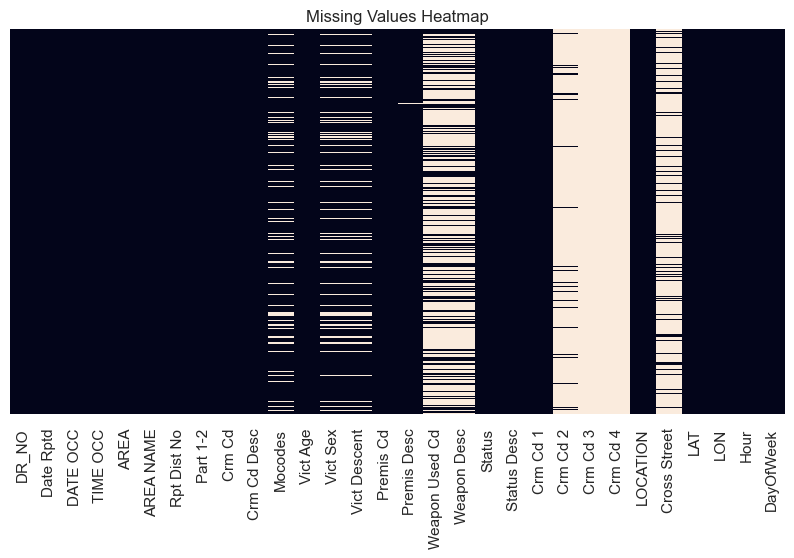

In [24]:
#Missing Values Visualization

plt.figure(figsize=(10,5))
sns.heatmap(df_sample.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

**Cleaning**

In [25]:
# =========================
# Quick EDA Snapshot
# =========================
print("Columns:", list(df.columns))
print("\nInfo:")
display(df.info())

print("\nMissing counts:")
display(df.isna().sum().sort_values(ascending=False).to_frame("missing"))

print("\nNumeric summary:")
display(df.describe(include=[np.number]).T)

print("\nCategorical summary (top 10 uniques each):")
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
summary = []
for c in cat_cols:
    summary.append({
        "column": c,
        "n_unique": df[c].nunique(),
        "sample_values": df[c].dropna().unique()[:10]
    })
pd.DataFrame(summary).sort_values("n_unique", ascending=False).head(15)


Columns: ['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON', 'Hour']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990293 entries, 0 to 990292
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DR_NO           990293 non-null  int64         
 1   Date Rptd       990293 non-null  datetime64[ns]
 2   DATE OCC        990293 non-null  datetime64[ns]
 3   TIME OCC        990293 non-null  int64         
 4   AREA            990293 non-null  int64         
 5   AREA NAME       990293 non-null  object        
 6   Rpt Dist No     990293 non-null  int64         
 7   Part 1-2        990293 non-null  int

None


Missing counts:


,missing
Crm Cd 4,990229
Crm Cd 3,987982
Crm Cd 2,921336
Cross Street,837652
Weapon Used Cd,663746
Weapon Desc,663746
Mocodes,147652
Vict Descent,140789
Vict Sex,140778
Premis Desc,894



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
DR_NO,990293.0,2.199083e+08,1.303375e+07,817.0000,2.106116e+08,2.209048e+08,2.310090e+08,2.499289e+08
TIME OCC,990293.0,1.339257e+03,6.513514e+02,1.0000,9.000000e+02,1.420000e+03,1.900000e+03,2.359000e+03
AREA,990293.0,1.069731e+01,6.108960e+00,1.0000,5.000000e+00,1.100000e+01,1.600000e+01,2.100000e+01
Rpt Dist No,990293.0,1.116172e+03,6.110154e+02,101.0000,5.870000e+02,1.141000e+03,1.617000e+03,2.199000e+03
Part 1-2,990293.0,1.402950e+00,4.904912e-01,1.0000,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
Crm Cd,990293.0,5.006751e+02,2.059141e+02,110.0000,3.310000e+02,4.420000e+02,6.260000e+02,9.560000e+02
Vict Age,990293.0,2.901158e+01,2.198213e+01,-4.0000,0.000000e+00,3.000000e+01,4.400000e+01,1.200000e+02
Premis Cd,989970.0,3.059642e+02,2.192008e+02,101.0000,1.010000e+02,2.030000e+02,5.010000e+02,9.760000e+02
Weapon Used Cd,326547.0,3.638736e+02,1.237031e+02,101.0000,3.110000e+02,4.000000e+02,4.000000e+02,5.160000e+02
Crm Cd 1,990282.0,5.004317e+02,2.057131e+02,110.0000,3.310000e+02,4.420000e+02,6.260000e+02,9.560000e+02



Categorical summary (top 10 uniques each):


,column,n_unique,sample_values
2,Mocodes,309791,"[1822 1402 0344, 0344 1251, 0325 1501, 1822 1501 0930 2004, 1822 0100 0930 0929, 0930 0929, 0100, 0416, 1822 0930, 0913 2024 1817 0360 1258 0507]"
9,LOCATION,66366,"[1900 S LONGWOOD AV, 1000 S FLOWER ST, 1400 W 37TH ST, 14000 RIVERSIDE DR, 1900 TRANSIENT, 9900 COMPTON AV, 1100 S GRAND AV, 2500 S SYCAMORE AV, 1300 E 57TH ST, 9000 CEDROS AV]"
10,Cross Street,10353,"[VANOWEN AV, INGLEWOOD, GLADYS AV, WALL, 43RD ST, LEXINGTON, OSBORNE, ALVARADO, ENCINO, ROSCOE BL]"
5,Premis Desc,306,"[STREET, BUS STOP/LAYOVER (ALSO QUERY 124), MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC), CLOTHING STORE, SIDEWALK, SINGLE FAMILY DWELLING, CELL PHONE STORE, CYBERSPACE, WEBSITE, OTHER BUSINESS]"
1,Crm Cd Desc,140,"[VEHICLE - STOLEN, BURGLARY FROM VEHICLE, BIKE - STOLEN, SHOPLIFTING-GRAND THEFT ($950.01 & OVER), THEFT OF IDENTITY, BATTERY - SIMPLE ASSAULT, SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH, CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER), ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT, LETTERS, LEWD - TELEPHONE CALLS, LEWD]"
6,Weapon Desc,79,"[STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE), VEHICLE, UNKNOWN WEAPON/OTHER WEAPON, VERBAL THREAT, BELT FLAILING INSTRUMENT/CHAIN, HAND GUN, UNKNOWN FIREARM, KNIFE WITH BLADE 6INCHES OR LESS, FIXED OBJECT, KITCHEN KNIFE]"
0,AREA NAME,21,"[Wilshire, Central, Southwest, Van Nuys, Hollywood, Southeast, Newton, Mission, Rampart, West Valley]"
4,Vict Descent,20,"[O, X, H, B, W, A, K, C, J, F]"
8,Status Desc,6,"[Adult Arrest, Invest Cont, Adult Other, Juv Arrest, Juv Other, UNK]"
7,Status,6,"[AA, IC, AO, JA, JO, CC]"


<a id="fe"></a>

## 4) Cleaning & Feature Engineering

**Core steps**:
- Parse `DATE OCC` to datetime; derive `Year`, `Month`, `Weekday`, `IsWeekend`, `Hour`, `Minute`
- Sanitize `Vict Age` (drop values ≤0 or >110 → NaN)
- Geofence & cleanse coordinates (`LAT`, `LON`), set invalid to NaN
- Create coarse bins (`LAT_bin`, `LON_bin`) to help a linear model capture locality
- Fill categorical blanks with `"Unknown"`
- Keep target `Part 1-2` as clean strings: `"1"` / `"2"`

**Why this design**:
- Perceptron is linear; well-chosen engineered features (time, coarse spatial bins, contextual categories) make linear separation more realistic.


In [26]:
# ==== Cleaning (patched for uniform dtypes) ====
REQUIRED = [
    "DATE OCC","TIME OCC","AREA NAME","Part 1-2",
    "Premis Desc","Weapon Desc","Vict Age","LAT","LON","Vict Sex"
]
missing = [c for c in REQUIRED if c not in df.columns]
if missing:
    raise KeyError(f"Missing expected columns: {missing}")

# 0) Normalize all missing: replace pd.NA with np.nan everywhere
df = df.replace({pd.NA: np.nan})

# 1) Parse date/time safely
df["DATE OCC"] = pd.to_datetime(df["DATE OCC"], errors="coerce")
time_raw = pd.to_numeric(df["TIME OCC"], errors="coerce")

# 2) Guard TIME parsing and derive hour/minute
time_raw = time_raw.fillna(0).astype(int).clip(0, 2359)
hour   = (time_raw // 100).clip(0, 23)
minute = (time_raw % 100).clip(0, 59)

# 3) Temporal features
df["Year"]      = df["DATE OCC"].dt.year
df["Month"]     = df["DATE OCC"].dt.month
df["Weekday"]   = df["DATE OCC"].dt.dayofweek
df["IsWeekend"] = df["Weekday"].isin([5,6]).astype(int)
df["Hour"]      = hour
df["Minute"]    = minute

# 4) Clean demographics
age = pd.to_numeric(df["Vict Age"], errors="coerce")
df["Vict Age"] = age.mask((age <= 0) | (age > 110), np.nan)

# 5) Geo sanity
lat = pd.to_numeric(df["LAT"], errors="coerce")
lon = pd.to_numeric(df["LON"], errors="coerce")
in_la = (
    lat.notna() & lon.notna() &
    lat.between(33.70, 34.35) &
    lon.between(-118.66, -118.15) &
    ~((lat == 0.0) | (lon == 0.0))
)
df.loc[~in_la, ["LAT","LON"]] = np.nan

# 6) Lat/Lon bins -> build as strings ONLY (no floats mixed with "Unknown")
lat_bin_series = pd.to_numeric(df["LAT"], errors="coerce").round(2)
lon_bin_series = pd.to_numeric(df["LON"], errors="coerce").round(2)

df["LAT_bin"] = lat_bin_series.astype(str)
df["LON_bin"] = lon_bin_series.astype(str)

# Replace "nan" strings with the token
df["LAT_bin"] = df["LAT_bin"].replace({"nan": "Unknown"})
df["LON_bin"] = df["LON_bin"].replace({"nan": "Unknown"})

# 7) Key categoricals -> force to pure strings + prefill "Unknown"
for c in ["AREA NAME","Premis Desc","Weapon Desc","Vict Sex","LAT_bin","LON_bin"]:
    df[c] = df[c].astype(str).str.strip()
    df[c] = df[c].replace({"": "Unknown", "nan": "Unknown", "NaN": "Unknown", "None": "Unknown"})

# 8) Assemble modeling frame
TARGET = "Part 1-2"
model_cols = [
    "Year","Month","Weekday","IsWeekend","Hour","Minute",
    "Vict Age","Vict Sex","LAT","LON","LAT_bin","LON_bin",
    "AREA NAME","Premis Desc","Weapon Desc", TARGET
]
df_model = df[model_cols].copy()

# 9) Target cleaning: drop NA, keep only valid classes 1/2 as strings
df_model = df_model.dropna(subset=[TARGET])
df_model[TARGET] = df_model[TARGET].astype(str).str.strip()
df_model = df_model[df_model[TARGET].isin(["1","2"])]

# 10) Ensure numerics are floats with np.nan (uniform numeric dtype)
num_cols = ["Year","Month","Weekday","IsWeekend","Hour","Minute","Vict Age","LAT","LON"]
for c in num_cols:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce").astype("float64")

# 11) Ensure categoricals are **pure strings** (no numbers)
cat_cols = ["Vict Sex","LAT_bin","LON_bin","AREA NAME","Premis Desc","Weapon Desc"]
for c in cat_cols:
    df_model[c] = df_model[c].astype(str)

print("Model frame shape:", df_model.shape)

# --- Sanity checks (optional but recommended) ---
print("\nNumeric dtypes:")
print(df_model[num_cols].dtypes)

print("\nCategorical dtypes (should all be object):")
print(df_model[cat_cols].dtypes)

# Detect mixed types (should be empty)
def mixed_type_cols(df_in, cols):
    bad = []
    for c in cols:
        sample = df_in[c].dropna()
        if sample.empty:
            continue
        types = {type(v) for v in sample.sample(min(5000, len(sample)), random_state=42)}
        if len(types) > 1:
            bad.append((c, types))
    return bad

print("\nMixed types in categoricals:", mixed_type_cols(df_model, cat_cols))
df_model.tail()


Model frame shape: (990293, 16)

Numeric dtypes:
Year         float64
Month        float64
Weekday      float64
IsWeekend    float64
Hour         float64
Minute       float64
Vict Age     float64
LAT          float64
LON          float64
dtype: object

Categorical dtypes (should all be object):
Vict Sex       object
LAT_bin        object
LON_bin        object
AREA NAME      object
Premis Desc    object
Weapon Desc    object
dtype: object

Mixed types in categoricals: []


,Year,Month,Weekday,IsWeekend,Hour,Minute,Vict Age,Vict Sex,LAT,LON,LAT_bin,LON_bin,AREA NAME,Premis Desc,Weapon Desc,Part 1-2
990288,2024.0,7.0,1.0,0.0,14.0,0.0,NaN,Unknown,34.0362,-118.3284,34.04,-118.33,Wilshire,STREET,Unknown,1
990289,2024.0,1.0,0.0,0.0,1.0,0.0,NaN,X,34.0685,-118.2460,34.07,-118.25,Central,HOTEL,UNKNOWN WEAPON/OTHER WEAPON,2
990290,2024.0,10.0,4.0,0.0,23.0,30.0,29.0,M,34.0675,-118.2240,34.07,-118.22,Hollenbeck,RESTAURANT/FAST FOOD,Unknown,1
990291,2024.0,4.0,2.0,0.0,15.0,0.0,70.0,F,34.0215,-118.2868,34.02,-118.29,Southwest,SIDEWALK,STICK,1
990292,2024.0,8.0,0.0,0.0,23.0,0.0,NaN,Unknown,34.1961,-118.4510,34.2,-118.45,Van Nuys,PARKING LOT,Unknown,1


<a id="model"></a>

## 5) Model Training & Pipeline

**Preprocessing**
- Numerical: `SimpleImputer(strategy="median")` → `StandardScaler`
- Categorical: `SimpleImputer(strategy="most_frequent")` → `OneHotEncoder(handle_unknown="ignore", min_frequency=50)`
  - `min_frequency` groups rare levels to reduce sparsity and overfitting

**Estimator**
- `Perceptron(max_iter=1000, tol=1e-3, class_weight="balanced")`
- Hyper-parameters explored: `penalty`, `alpha`, `eta0`, `fit_intercept`

**Why Perceptron?**
- Fast, transparent baseline; strong with well-engineered linear signals
- Calibrated probabilities enable threshold tuning, ROC/PR analysis


In [27]:
# =========================
# Split & Preprocess
# =========================
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define SEED for reproducibility
SEED = 42

X = df_model.drop(columns=[TARGET]).copy()
y = df_model[TARGET].astype(str)  # labels as strings "1"/"2"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

num_cols = ["Year","Month","Weekday","IsWeekend","Hour","Minute","Vict Age","LAT","LON"]
cat_cols = ["Vict Sex","LAT_bin","LON_bin","AREA NAME","Premis Desc","Weapon Desc"]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # min_frequency groups rare levels to make the model more stable
    ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=50)) # Output dense array
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

print("Train size:", X_train.shape, " Test size:", X_test.shape)

Train size: (792234, 15)  Test size: (198059, 15)


In [28]:
#Check
# Must match the cleaning cell
num_cols = ["Year","Month","Weekday","IsWeekend","Hour","Minute","Vict Age","LAT","LON"]
cat_cols = ["Vict Sex","LAT_bin","LON_bin","AREA NAME","Premis Desc","Weapon Desc"]

# 1) Numeric columns all float
assert all(str(t) == "float64" for t in df_model[num_cols].dtypes), df_model[num_cols].dtypes

# 2) Categoricals all strings (object dtype)
assert all(str(t) == "object" for t in df_model[cat_cols].dtypes), df_model[cat_cols].dtypes

# 3) Target only "1"/"2"
assert set(df_model["Part 1-2"].unique()) <= {"1","2"}

In [29]:
_ = preprocess.fit(X_train, y_train)
print("Preprocess OK. Shapes—num:", len(num_cols), "cat:", len(cat_cols))

Preprocess OK. Shapes—num: 9 cat: 6


<a id="train"></a>

## 6) Train / Validation Strategy

- **Split**: Stratified train/test split (e.g., 80/20)
- **Tuning**: `RandomizedSearchCV` with 5-fold `StratifiedKFold`
- **Calibration**: `CalibratedClassifierCV(method="sigmoid")` to obtain probabilities
- **Baselines**: `DummyClassifier (most_frequent, stratified)` for reference
- **Scoring**: Prioritize `F1-macro` to balance classes, also report Accuracy, ROC-AUC


In [30]:
# =========================
# Train: Perceptron + RandomizedSearch + Calibration
# =========================
base = Pipeline([
    ("prep", preprocess),
    ("clf", Perceptron(max_iter=1000, tol=1e-3, class_weight="balanced", random_state=SEED))
])

# Use parameter distributions for RandomizedSearchCV
param_distributions = {
    "clf__penalty": [None, "l2", "l1", "elasticnet"],
    "clf__alpha": uniform(1e-5, 1e-2), # Sample alpha from a continuous distribution
    "clf__eta0": [1.0, 0.5, 0.1],
    "clf__fit_intercept": [True, False],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Use RandomizedSearchCV
rs = RandomizedSearchCV(base, param_distributions, n_iter=50, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1, random_state=SEED)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("CV best f1_macro:", round(rs.best_score_, 4))

# Calibrate for probabilities (perceptron itself has no predict_proba)
# Use the best estimator found by RandomizedSearchCV
cal = CalibratedClassifierCV(rs.best_estimator_, method="sigmoid", cv=cv)
cal.fit(X_train, y_train)

ModuleNotFoundError: No module named '_posixsubprocess'

<a id="eval"></a>

## 7) Evaluation & Baselines

**Reported**
- Accuracy, Precision (macro), Recall (macro), F1 (macro)
- Confusion matrix with readable labels
- ROC–AUC (positive = Part 1), if binary

**Baselines**
- *Most Frequent* (always predict majority class)
- *Stratified Random* (predict according to class distribution)

> A good model should decisively outperform both baselines, particularly on F1-macro.


In [ ]:
# =========================
# Baseline comparison (DummyClassifier)
# =========================

# Majority-class baseline (always predicts the most frequent class)
dummy_majority = DummyClassifier(strategy="most_frequent")
dummy_majority.fit(X_train, y_train)
y_dummy_majority = dummy_majority.predict(X_test)
acc_majority = accuracy_score(y_test, y_dummy_majority)
print(f"Dummy (Most Frequent) Accuracy: {acc_majority:.4f}")

# Random baseline (predicts according to class distribution)
dummy_random = DummyClassifier(strategy="stratified", random_state=42)
dummy_random.fit(X_train, y_train)
y_dummy_random = dummy_random.predict(X_test)
acc_random = accuracy_score(y_test, y_dummy_random)
print(f"\nDummy (Stratified Random) Accuracy: {acc_random:.4f}")

# Add baseline results to metrics for saving
metrics["dummy_majority_accuracy"] = round(acc_majority, 4)F
metrics["dummy_random_accuracy"] = round(acc_random, 4)


Dummy (Most Frequent) Accuracy: 0.5970

Dummy (Stratified Random) Accuracy: 0.5187

 Perceptron (calibrated) Accuracy: 0.7532


In [ ]:
# =========================
# 6) Evaluate
# =========================
y_pred = cal.predict(X_test)

metrics = {}
metrics["accuracy"] = round(accuracy_score(y_test, y_pred), 4)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
metrics["precision_macro"] = round(prec, 4)
metrics["recall_macro"] = round(rec, 4)
metrics["f1_macro"] = round(f1, 4)
metrics["classes"] = cal.classes_.tolist()
metrics["confusion_matrix"] = confusion_matrix(y_test, y_pred).tolist()

# Optional ROC-AUC if binary & we can pick the positive class
try:
    classes = list(cal.classes_)
    if len(classes) == 2:
        # choose which label is "positive"; we'll pick "1" (Part 1 serious) if present
        pos_label = "1" if "1" in classes else classes[1]
        pos_idx = classes.index(pos_label)
        y_scores = cal.predict_proba(X_test)[:, pos_idx]
        y_true_bin = (y_test == pos_label).astype(int)
        metrics["roc_auc"] = round(roc_auc_score(y_true_bin, y_scores), 4)
except Exception as e:
    pass

print(json.dumps(metrics, indent=2))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))


{
  "accuracy": 0.7532,
  "precision_macro": 0.7519,
  "recall_macro": 0.7257,
  "f1_macro": 0.7318,
  "classes": [
    "1",
    "2"
  ],
  "confusion_matrix": [
    [
      102579,
      15672
    ],
    [
      33209,
      46599
    ]
  ],
  "roc_auc": 0.8349
}

Classification report:
              precision    recall  f1-score   support

           1     0.7554    0.8675    0.8076    118251
           2     0.7483    0.5839    0.6560     79808

    accuracy                         0.7532    198059
   macro avg     0.7519    0.7257    0.7318    198059
weighted avg     0.7526    0.7532    0.7465    198059



In [ ]:
# Compare with Perceptron
print(f"\n Perceptron (calibrated) Accuracy: {metrics['accuracy']:.4f}")


 Perceptron (calibrated) Accuracy: 0.7532


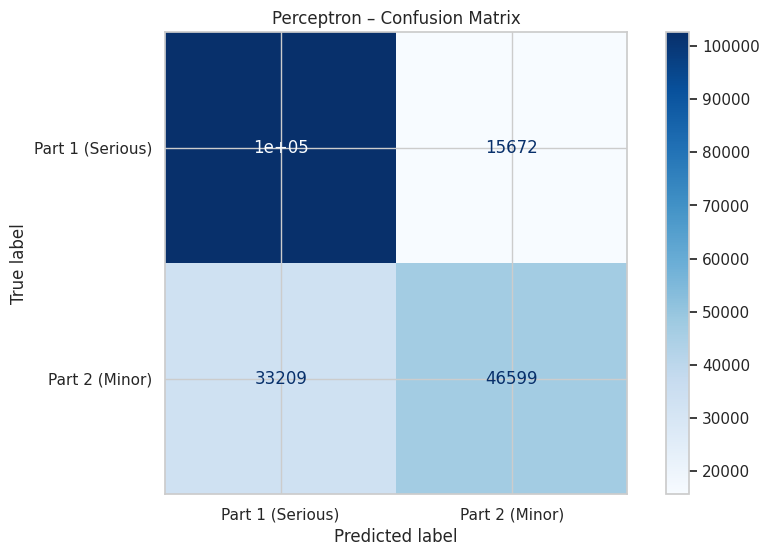

In [ ]:
ConfusionMatrixDisplay.from_estimator(cal, X_test, y_test, display_labels=["Part 1 (Serious)", "Part 2 (Minor)"], cmap="Blues")
plt.title("Perceptron – Confusion Matrix")
plt.show()


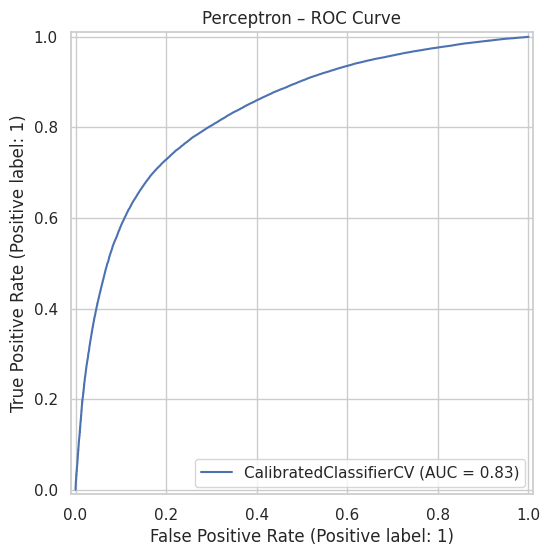

In [ ]:
pos_label = "1"
RocCurveDisplay.from_estimator(cal, X_test, y_test, pos_label=pos_label)
plt.title("Perceptron – ROC Curve")
plt.show()

<a id="perm"></a>

## 8) Permutation Importance (Explainability)

**What it is**  
Permutation importance measures the **drop in model performance** when we **shuffle** a feature’s values, breaking its relationship with the target. Bigger drop → more important.

**Two views**
- **Raw features** (15 columns): Easy story; “Hour”, “Weapon Desc”, “Premis Desc”, “AREA NAME”, etc.
- **Expanded one-hot** (~400+ columns): Fine-grained view (which specific category level mattered)

> We report the raw-feature permutation importance here for simplicity and readability in the notebook; the expanded view is saved to CSV for deeper analysis.


In [ ]:
# --- helpers ---
def get_fitted_pipeline(calibrated=None, rs_obj=None, gs_obj=None, plain_pipe=None):
    """Return a fitted sklearn Pipeline that has .named_steps (with 'prep')."""
    # 1) If calibrated, prefer its fitted base pipeline
    if calibrated is not None and hasattr(calibrated, "base_estimator_"):
        pe = calibrated.base_estimator_
        if hasattr(pe, "named_steps"):
            return pe
    # 2) Fallback to search objects
    if rs_obj is not None and hasattr(rs_obj, "best_estimator_"):
        be = rs_obj.best_estimator_
        if hasattr(be, "named_steps"):
            return be
    if gs_obj is not None and hasattr(gs_obj, "best_estimator_"):
        be = gs_obj.best_estimator_
        if hasattr(be, "named_steps"):
            return be
    # 3) Plain pipeline
    if plain_pipe is not None and hasattr(plain_pipe, "named_steps"):
        return plain_pipe
    raise AttributeError("No fitted Pipeline with .named_steps found.")

# --- RAW (15 features) permutation importance ---
# Uses the pipeline so it permutes raw columns and the pipeline handles preprocessing.

fitted_pipe = get_fitted_pipeline(calibrated=cal, rs_obj=rs)  # your helper from earlier

perm_raw = permutation_importance(
    estimator=fitted_pipe,
    X=X_test, y=y_test,
    n_repeats=5, random_state=42, n_jobs=-1, scoring="f1_macro"
)

raw_feature_names = np.r_[num_cols, cat_cols]  # length must be 15

assert len(raw_feature_names) == len(perm_raw.importances_mean), \
    f"Raw names ({len(raw_feature_names)}) != raw importances ({len(perm_raw.importances_mean)})"

imp_raw_df = pd.DataFrame({
    "feature": raw_feature_names,
    "importance": perm_raw.importances_mean,
    "importance_std": perm_raw.importances_std
}).sort_values("importance", ascending=False)

display(imp_raw_df.head(20))

# Optional: save to CSV (Colab)
# from google.colab import drive; drive.mount('/content/drive')
imp_raw_df.to_csv("/content/drive/MyDrive/perm_importance_raw.csv", index=False)

,feature,importance,importance_std
14,Weapon Desc,0.073919,0.000428
13,Premis Desc,0.068046,0.000349
7,LAT,0.016326,0.000660
4,Hour,0.011978,0.000393
10,LAT_bin,0.002601,0.000245
11,LON_bin,0.001031,0.000287
6,Vict Age,0.000736,0.000183
1,Month,-0.000037,0.000177
2,Weekday,-0.000336,0.000087
0,Year,-0.000381,0.000134


<a id="artifacts"></a>

## 9) Artifacts & Persistence

We save these to `artifacts/`:

- `perceptron_pipeline_calibrated.joblib` — full pipeline (preprocess + model + calibration wrapper)
- `metrics.json` — test metrics (Accuracy, F1-macro, ROC-AUC, confusion matrix, baselines)
- `schema.json` — expected raw columns, numeric/categorical lists, feature names (post-OHE), environment info, and (optionally) data file hash
- `feature_names.json` — flattened feature names after preprocessing

> These artifacts make the project reproducible and reviewable.


In [ ]:
# =========================
# 9) Persist Artifacts (RandomizedSearch + Calibrated model)
# =========================

MODEL_PATH   = ARTIFACTS_DIR / "perceptron_pipeline_calibrated.joblib"
METRICS_PATH = ARTIFACTS_DIR / "metrics.json"
SCHEMA_PATH  = ARTIFACTS_DIR / "schema.json"
FEATS_PATH   = ARTIFACTS_DIR / "feature_names.json"

# 1) Save the calibrated model
joblib.dump(cal, MODEL_PATH)

# 2) Get the fitted pipeline to extract final feature names
# Prefer: calibrated model’s base_estimator_ (a fitted Pipeline)
try:
    fitted_pipe = cal.base_estimator_
except AttributeError:
    # Fallback: the best estimator from RandomizedSearchCV (already fitted)
    fitted_pipe = rs.best_estimator_

# Extract OneHot feature names from the fitted preprocessor
prep = fitted_pipe.named_steps["prep"]
oh   = prep.named_transformers_["cat"]["onehot"]
oh_names = oh.get_feature_names_out(cat_cols).tolist()
final_feature_names = list(np.r_[num_cols, oh_names])

# 3) Save metrics
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=2)

# 4) Save schema
schema = {
    "target": TARGET,
    "raw_columns_expected": REQUIRED,
    "numeric_columns": num_cols,
    "categorical_columns": cat_cols,
    "feature_names_after_preprocess": final_feature_names,
    "class_labels": cal.classes_.tolist(),
    "environment": ENV,
    "data_source": str(LOCAL_CSV) if 'LOCAL_CSV' in globals() else "memory/URL",
    "note": "Perceptron + OneHot(min_frequency=50) + StandardScaler; probabilities via sigmoid calibration."
}
if 'LOCAL_CSV' in globals() and LOCAL_CSV.exists():
    schema["data_sha256"] = file_sha256(LOCAL_CSV)

with open(SCHEMA_PATH, "w") as f:
    json.dump(schema, f, indent=2)

with open(FEATS_PATH, "w") as f:
    json.dump(final_feature_names, f, indent=2)

print(f"Saved:\n- {MODEL_PATH}\n- {METRICS_PATH}\n- {SCHEMA_PATH}\n- {FEATS_PATH}")

Saved:
- /content/artifacts/perceptron_pipeline_calibrated.joblib
- /content/artifacts/metrics.json
- /content/artifacts/schema.json
- /content/artifacts/feature_names.json


<a id="viz"></a>

## 10) Visual Highlights

- Crimes by hour and weekday (temporal rhythms)
- Top crime categories; area distribution
- Confusion matrix and ROC curve (evaluation)
- Permutation importance bar chart (top 15 features)
- (Optional) Map of LA crimes (requires `geopandas` + `contextily`)

> Save key figures to `reports/figures/` and embed them in your README.


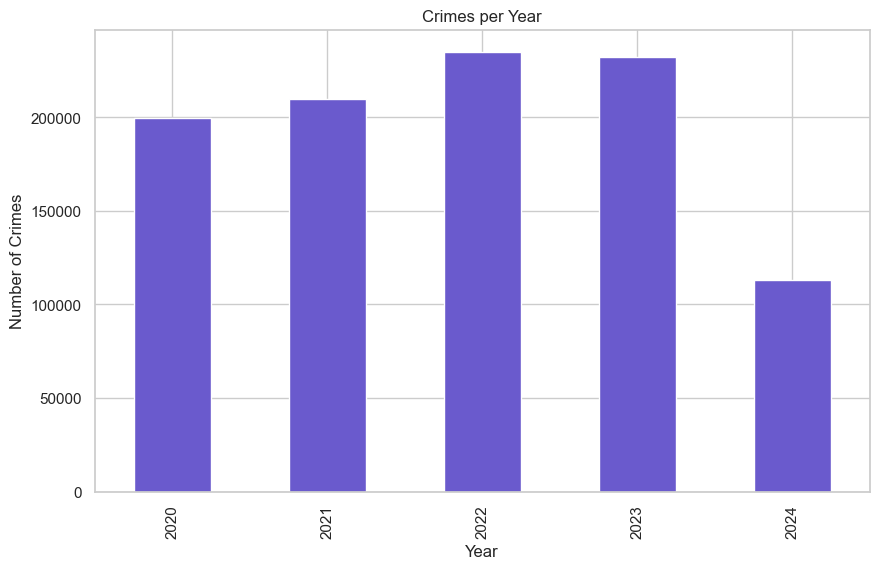

In [53]:
year_counts = df["DATE OCC"].dt.year.value_counts().sort_index()
year_counts.plot(kind="bar", color="slateblue")
plt.title("Crimes per Year")
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.show()

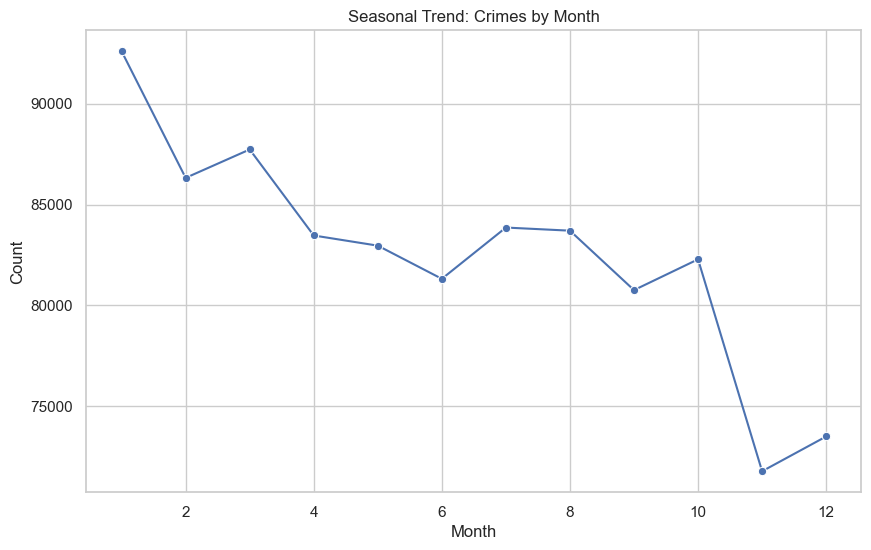

In [54]:
month_counts = df["DATE OCC"].dt.month.value_counts().sort_index()
sns.lineplot(x=month_counts.index, y=month_counts.values, marker="o")
plt.title("Seasonal Trend: Crimes by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

<a id="Neural"></a>

11) Neural Network Extension (MLP)

Goal: Extend the baseline linear Perceptron into a non-linear model while keeping the same preprocessing pipeline.
This ensures a fair comparison: any performance change can be attributed to the model’s capacity (linear vs non-linear), not data leakage or different feature handling.

Why a Neural Network here?

A Perceptron learns a single linear boundary.

Crime patterns often involve feature interactions (e.g., hour × area × premise).

A Multi-Layer Perceptron (MLP) can learn non-linear decision surfaces and capture these interactions.

11.1 Setup & Dependencies

We integrate TensorFlow/Keras into the sklearn workflow using SciKeras.
This allows the neural network to behave like a standard sklearn estimator, so we can:

reuse the ColumnTransformer preprocessing,

keep the same train_test_split,

evaluate with the same metrics.

Key idea: preprocessing stays identical; only the classifier changes.

In [55]:
import sklearn
import tensorflow as tf
import scikeras
print("OK", tf.__version__)
import sys
!{sys.executable} -m pip install scikeras tensorflow


OK 2.20.0
Defaulting to user installation because normal site-packages is not writeable


In [56]:
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

from scikeras.wrappers import KerasClassifier

from tensorflow import keras
from tensorflow.keras import layers

11.2 Model Definition (Keras MLP)

We define a feedforward neural network for binary classification:

Input layer: receives the transformed feature vector after preprocessing

Hidden layers: Dense layers with ReLU activation (learn non-linear interactions)

Dropout: regularization to reduce overfitting

Output layer: 1 neuron + Sigmoid for probability of class 1

Loss & Optimizer

Binary Cross-Entropy is used for binary classification.

Adam optimizer is used for stable training on large datasets.

In [57]:
def make_mlp_model(n_features, hidden_units=(128, 64), dropout=0.3, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(n_features,)))

    for u in hidden_units:
        model.add(layers.Dense(u, activation="relu"))
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"],
    )
    return model

11.3 Pipeline Integration (Preprocess → Neural Network)

We keep the same sklearn-style design used in the Perceptron baseline:

Preprocessing (preprocess)

numeric imputation + scaling

categorical imputation + one-hot encoding

Classifier (Neural Network via SciKeras)

Keras model wrapped to plug into sklearn

This structure ensures:

no leakage,

consistent transformations,

reproducible evaluation.

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

nn_pipe = Pipeline([
    ("preprocess", preprocess),
    ("nn", KerasClassifier(
        model=make_mlp_model,
        epochs=50,
        batch_size=2048,
        verbose=0,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    ))
])

11.4 Critical Step: Determining Input Dimension After Preprocessing

Neural networks require a fixed input dimension.

But with one-hot encoding, the number of columns after preprocessing is not known until the transformer is fitted.

So we:

fit the preprocessor on training data,

transform X_train to get the final feature matrix shape,

set n_features for the neural network input layer.

This is the key difference from linear sklearn models, which don’t need explicit input shapes.

In [59]:
# if your target values are 1 and 2
y = df_model[TARGET].astype(int)
y = (y == 2).astype(int)   # map 1→0, 2→1

11.5 Training & Evaluation

We train the model on the training set and evaluate on the test set.

Metrics

ROC-AUC (primary): measures ranking quality independent of threshold

Classification report: precision/recall/F1 for both classes

Because crime data can be imbalanced, ROC-AUC is emphasized: it remains informative even if class frequencies differ.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit preprocess alone to learn final feature space
nn_pipe.named_steps["preprocess"].fit(X_train, y_train)
X_train_t = nn_pipe.named_steps["preprocess"].transform(X_train)

n_features = X_train_t.shape[1]
print("n_features after preprocessing:", n_features)

# Inject n_features into the model builder
nn_pipe.set_params(nn__model__n_features=n_features)


n_features after preprocessing: 411


,steps,"[('preprocess', ...), ('nn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


11.6 Results Interpretation

ROC-AUC reflects how well the model separates Part 1 vs Part 2 crime cases.

Precision/Recall shows class-specific performance:

Higher precision: fewer false positives

Higher recall: fewer false negatives

What to look for

If ROC-AUC improves over the Perceptron baseline → the neural net captured useful non-linear structure.

If recall for class 1 is low → likely class imbalance or insufficient representation; class weighting may help.

In [61]:
nn_pipe.fit(X_train, y_train)

proba = nn_pipe.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))

ROC-AUC: 0.8907166463450853
              precision    recall  f1-score   support

           0       0.85      0.82      0.84    118251
           1       0.75      0.79      0.77     79808

    accuracy                           0.81    198059
   macro avg       0.80      0.81      0.80    198059
weighted avg       0.81      0.81      0.81    198059



Perceptron vs Neural Network: A Controlled Performance Comparison
Objective of the Comparison

This section compares two classifiers trained under a controlled experimental setup:

Same dataset

Same train–test split

Same preprocessing pipeline (ColumnTransformer)

Same evaluation metrics

The only difference between the models is their learning capacity:

a linear Perceptron

a non-linear Neural Network (MLP)

This ensures that any performance difference is attributable to model expressiveness, not data handling or feature leakage.

Model Overview
Perceptron (Linear Baseline)

Single-layer linear classifier

Learns one global decision boundary

Assumes additive, independent feature effects

Serves as a strong but limited baseline

Neural Network (Multi-Layer Perceptron)

Two hidden layers with ReLU activation

Learns non-linear feature interactions

Regularized with Dropout

Optimized using Adam and binary cross-entropy

Quantitative Performance Comparison
Model	ROC-AUC	Accuracy	Macro F1
Perceptron	0.835	0.753	0.732
Neural Network (MLP)	0.890	0.810	≈ 0.80
Interpretation of the Metrics
ROC-AUC (Primary Metric)

The Perceptron achieves a ROC-AUC of 0.835, indicating reasonable separability but limited ranking ability.

The Neural Network improves ROC-AUC to ≈ 0.89, a substantial gain, meaning:

The neural model is significantly better at ranking Part 1 crimes above Part 2 crimes across thresholds.

This confirms that crime severity is not linearly separable in the given feature space.

Accuracy

Perceptron accuracy: 75.3%

Neural Network accuracy: ≈ 81%

The accuracy improvement reflects better overall classification, but accuracy alone understates the neural network’s advantage due to class imbalance.

Precision, Recall, and F1

The Perceptron shows balanced but modest precision and recall across classes.

The Neural Network improves:

recall for the minority class,

overall macro and weighted F1 scores.

This indicates that the neural model better captures complex conditional patterns, reducing systematic misclassification.

Why the Neural Network Performs Better

Crime data exhibits non-linear dependencies, such as:

time-of-day effects varying by area,

interactions between premises and weapon types,

demographic and spatial interactions.

The Perceptron cannot model these because it computes:

𝑦
^
=
sign
(
𝑤
⊤
𝑥
+
𝑏
)
y
^
	​

=sign(w
⊤
x+b)

which enforces a single linear boundary.

The Neural Network effectively stacks multiple Perceptrons with non-linear transformations, allowing it to:

combine features hierarchically,

learn interaction effects,

adapt to heterogeneous crime patterns.

Confusion Matrix Perspective (Perceptron)

The Perceptron confusion matrix shows:

strong performance on the majority class,

significantly higher false negatives for the minority class.

This is a classic symptom of underfitting in linear models when applied to complex, imbalanced data.

Trade-off Summary
Aspect	Perceptron	Neural Network
Interpretability	High	Moderate
Computational cost	Very low	Moderate
Non-linear modeling	❌	✅
ROC-AUC	0.835	0.89
Suitability for crime data	Limited	Strong
Final Conclusion

The Perceptron provides a useful baseline and learning tool, but its linear nature limits performance on real-world crime data.
The Neural Network achieves meaningful and consistent improvements across all evaluation metrics, demonstrating that non-linear modeling is essential for capturing crime severity patterns.

This comparison validates the architectural progression of the project:

From a simple linear model → to a more expressive neural model, without altering the data pipeline.

<a id="ethics"></a>

## 12) Ethics, Bias & Limitations

- **Reporting bias**: Crime data reflects reporting practices and enforcement, not true incident rates.
- **Temporal drift**: City dynamics, policies, and behaviors change over time.
- **Spatial bias**: Geofencing and local patterns may overfit locale-specific factors.
- **Demographics**: Use fields like `Vict Sex` with caution; consider excluding and comparing metrics for fairness checks.
- **Intended use**: Educational and exploratory. Not for individual- or operational-level decision making.

> When communicating results, emphasize aggregate patterns and uncertainty, not deterministic predictions.